In [2]:
# main.py

import os
import pandas as pd
import logging

from geomeppy import IDF

# Your geometry / fenestration / etc. modules
from geomz.building import create_building_with_roof_type
from fenez.fenestration import add_fenestration
from fenez.materials import update_construction_materials, assign_constructions_to_surfaces
from Elec.lighting import add_lights_and_parasitics
from DHW.water_heater import add_dhw_to_idf
from HVAC.custom_hvac import add_HVAC_Ideal_to_all_zones
from ventilation.add_ventilation import add_ventilation_to_idf
from setzone.add_outdoor_air_and_zone_sizing_to_all_zones import add_outdoor_air_and_zone_sizing_to_all_zones
from tempground.add_ground_temperatures import add_ground_temperatures
from outputdef.assign_output_settings import assign_output_settings
from outputdef.add_output_definitions import add_output_definitions

# The final run-sims code
from epw.run_epw_sims import simulate_all

from postproc.merge_results import merge_all_results
from other.zonelist import create_zonelist




idf_config = {
    "iddfile": "D:/EnergyPlus/Energy+.idd",
    "idf_file_path": "D:/Minimal.idf",
    "output_dir": "D:/output_IDFs"
}

CALIBRATION_STAGE = "pre_calibration"
STRATEGY = "B"
RANDOM_SEED = 42

def create_idf_for_building(building_row, building_index, scenario, calibration_stage, strategy):
    """
    Builds an IDF for a single building row. Then we save it to disk and return the file name.
    """
    IDF.setiddname(idf_config["iddfile"])
    idf = IDF(idf_config["idf_file_path"])

    # 1) Building object
    building_obj = idf.newidfobject("BUILDING")
    building_obj.Name = f"Sample_Building_{building_index}"

    orientation = building_row.get("building_orientation", 0.0)
    if not pd.isna(orientation):
        building_obj.North_Axis = orientation

    # 2) Geometry
    edge_types = []
    for side_col in ["north_side", "east_side", "south_side", "west_side"]:
        edge_types.append(building_row.get(side_col, "facade"))

    create_building_with_roof_type(
        idf,
        area=building_row["area"],
        perimeter=building_row["perimeter"],
        orientation=orientation,
        building_row=building_row,
        edge_types=edge_types,
        calibration_stage=calibration_stage,
        strategy=strategy,
        random_seed=RANDOM_SEED
    )

    # 3) Materials & Constructions
    update_construction_materials(
        idf,
        building_row,
        scenario=scenario,
        calibration_stage=calibration_stage,
        strategy=strategy,
        random_seed=RANDOM_SEED
    )
    assign_constructions_to_surfaces(idf)

    # 4) Fenestration
    add_fenestration(
        idf,
        building_row,
        scenario=scenario,
        calibration_stage=calibration_stage,
        strategy=strategy,
        random_seed=RANDOM_SEED
    )

    create_zonelist(idf, zonelist_name="ALL_ZONES")


    # 5) Lighting
    add_lights_and_parasitics(
        idf,
        building_row,
        calibration_stage=calibration_stage,
        strategy=strategy,
        random_seed=RANDOM_SEED
    )

    # 6) DHW
    add_dhw_to_idf(
        idf,
        building_row=building_row,
        calibration_stage=calibration_stage,
        strategy=strategy,
        random_seed=RANDOM_SEED,
        name_suffix=f"MyDHW_{building_index}"
    )

    # 7) HVAC (Ideal Loads)
    add_HVAC_Ideal_to_all_zones(
        idf,
        calibration_stage=calibration_stage,
        strategy=strategy,
        random_seed=RANDOM_SEED
    )

    # 8) Ventilation
    add_ventilation_to_idf(idf, building_row=building_row)

    # 9) Zone sizing + OA
    add_outdoor_air_and_zone_sizing_to_all_zones(
        idf=idf,
        building_row=building_row,
        calibration_stage=calibration_stage,
        strategy=strategy,
        random_seed=RANDOM_SEED
    )

    # 10) Ground temperatures
    add_ground_temperatures(
        idf,
        calibration_stage=calibration_stage,
        strategy=strategy,
        random_seed=RANDOM_SEED
    )

    # 11) Output definitions
    desired_vars = ["Facility Total Electric Demand Power", "Zone Air Temperature Maximum"]
    desired_meters = ["Electricity:Facility"]

    out_settings = assign_output_settings(
        desired_variables=desired_vars,
        desired_meters=desired_meters,
        override_variable_frequency="Hourly",
        override_meter_frequency="Hourly",
        include_tables=True,
        include_summary=True
    )
    add_output_definitions(idf, out_settings)

    # 12) Save IDF to disk
    os.makedirs(idf_config["output_dir"], exist_ok=True)
    idf_filename = f"building_{building_index}.idf"
    out_path = os.path.join(idf_config["output_dir"], idf_filename)
    idf.save(out_path)
    print(f"[create_idf_for_building] IDF saved at: {out_path}")

    # Return just the file name (or full path) so we can reference it later
    return idf_filename

def main():
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    logging.info("Starting main...")

    # 1) Load building data
    df_buildings = pd.read_csv("df_buildings.csv")

    # 2) Suppose we define a list of 'desired_climate_year's. 
    #    In this example, we just store a single year per building. 
    #    If you want multiple, you can expand or replicate rows.

    # E.g., if you want to ensure every building has a 'desired_climate_year' column:
    # We'll assign 2020 for the first, 2050 for the second, etc. Or read from an array.
    desired_years = [2020, 2050]
    # for simplicity, match them row by row
    for i in range(len(df_buildings)):
        year = desired_years[i % len(desired_years)]
        df_buildings.loc[i, "desired_climate_year"] = year

    # 3) Create IDFs for each building & store the idf_name in the DF
    scenario = "scenario1"
    calibration_stage = "pre_calibration"
    strategy = "B"

    idf_names = []
    for idx, row in df_buildings.iterrows():
        print(f"--- Creating IDF for building index {idx} ---")
        idf_filename = create_idf_for_building(
            building_row=row,
            building_index=idx,
            scenario=scenario,
            calibration_stage=calibration_stage,
            strategy=strategy
        )
        # Store into df so run_epw_sims can find the file
        df_buildings.loc[idx, "idf_name"] = idf_filename

    # 4) Now we have df_buildings with columns lat, lon, desired_climate_year, idf_name
    #    We'll run them all in parallel using epw.run_epw_sims.simulate_all
    from epw.run_epw_sims import simulate_all

    # 2) Define all directories
    idf_directory = "D:/output_IDFs"  # where we saved the final .idf files for each building
    iddfile = "D:/EnergyPlus/Energy+.idd"
    base_output_dir = "D:/Sim_Results"
    num_workers = 4

    # 3) Finally, run all simulations => each year in a single folder
    simulate_all(
        df_buildings=df_buildings,
        idf_directory=idf_directory,
        iddfile=iddfile,
        base_output_dir=base_output_dir,
        num_workers=num_workers
    )

    # 3) Post-processing step
    out_csv_as_is = "merged_as_is.csv"
    out_csv_daily_mean = "merged_daily_mean.csv"
    
    

    # 1) Merge "as is" => no aggregation
    merge_all_results(
        base_output_dir=base_output_dir,
        output_csv=out_csv_as_is,
        convert_to_daily=False,
        convert_to_monthly=False
    )

    # 2) Convert Hourly/TimeStep to Daily => aggregator = mean
    merge_all_results(
        base_output_dir=base_output_dir,
        output_csv=out_csv_daily_mean,
        convert_to_daily=True,
        daily_aggregator="mean", # max, min, sum, pick_first_hour
        convert_to_monthly=False
    )

    print("All done post-processing.")

    
    



    logging.info("All done with main.")

if __name__ == "__main__":
    main()


ModuleNotFoundError: No module named 'geomz'

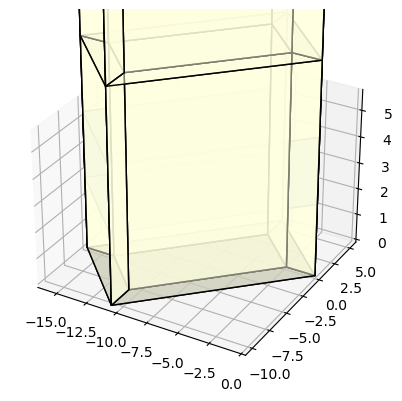

In [1]:
from geomeppy import IDF 
import os
from math import sqrt, radians, cos, sin

# Configuration - Update these paths as needed
idf_config = {
    "iddfile": "D:/EnergyPlus/Energy+.idd",
    "idf_file_path": "D:/output/building_1.idf",  # Updated path
    "output_dir": "D:/output"
}

# Ensure the output directory exists
os.makedirs(idf_config["output_dir"], exist_ok=True)

# Set the IDD file
IDF.setiddname(idf_config["iddfile"])

# Initialize the IDF object with the correct file path
idf = IDF(idf_config["idf_file_path"])

# View the IDF model
idf.view_model()
